# ***Optical Character Recognition Using Captcha Images***

<br>
For handling text-based CAPTCHAs, the project employs an Optical Character Recognition (OCR) framework, underpinned by a sophisticated Convolutional Recurrent Neural Network (CRNN). This network integrates a Connectionist Temporal Classification (CTC) output layer, crucial for decoding sequences without explicit segmentation. This configuration is designed to handle the varying distortions and styles inherent in CAPTCHA texts, thereby enhancing the model's adaptability and accuracy.
<br>
<br>
To run the code, simply select "Run all" and there is no need to alter the code unless you do not have the Large_Captcha_Dataset folder already provided to you. Otherwise, a valid kaggle.json file is required to access the [Large Captcha Dataset](https://www.kaggle.com/datasets/akashguna/large-captcha-dataset/data) hosted on Kaggle, and you must comment out the code to retrieve, download, and unpack the dataset properly.
<br>

***Prerequisites***:
<br>
Note that it is recommended to run these models while utilizing a GPU, or by utilizing a virtual machine (VM) through cloud hosted Jupyter Notebook services such as Colab. The following code was developed utilizing colab, and is thus most well suited to be ran through its services. 

*Colab*:
1. Main directory structure of
```
/content/drive/MyDrive/Colab Notebooks/Captcha CNN and OCR
```

2. Captcha data folder directory structure of
```
/content/drive/MyDrive/Colab Notebooks/Captcha CNN and OCR/Large_Captcha_Dataset
```



# Google Drive + Kaggle Setup

In [ ]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/Captcha CNN and OCR')

Mounted at /content/drive/


In [ ]:
# The code below is only necessary if the dataset is not currently in
# your directory. (For our purposes, the dataset is already stored and there is
# no need to run this code)

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# OCR Model for CAPTCHA Text Detection


In [ ]:
# import block
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# tensorflow loads keras lazily, resulting in an IDE bug
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, StringLookup
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.nn import ctc_loss
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby
from sklearn.model_selection import train_test_split

import random
from pathlib import Path

Load data and labeling

In [ ]:
# The code below is only necessary if the dataset is not currently in
# your directory. This will require creating a kaggle.json file and
# including it in your pwd.

# ! kaggle datasets download akashguna/large-captcha-dataset
# ! unzip large-captcha-dataset.zip


In [ ]:
# load data_PATH AND IMAGES/FILENAMES VARIABLES
data_path = Path('/content/drive/MyDrive/Colab Notebooks/Captcha CNN and OCR/Large_Captcha_Dataset')

In [ ]:
# creating the labels
images = []
gray_images = []
filenames = []

for filename in os.listdir(data_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(data_path, filename)
        try:
            with Image.open(img_path) as img:
                images.append(img_path)
                # gray_images.append(tf.image.rgb_to_grayscale(img_path))
                filenames.append(filename)
        except IOError:
            pass

labels = [filename.split('.')[0] for filename in filenames]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  82328
Number of labels found:  82328
Number of unique characters:  62
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Hyper-parameters for Image Processing + CRNN Training

In [ ]:
batch_size = 128
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
clip_norm = 1.0

num_epochs = 100
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate
)

img_width = 256
img_height = 80
downsample_factor = 4
max_length = max([len(label) for label in labels])

**Image Processing + Training/Testing Split**

In [ ]:
# mapping characters to integers
# char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
char_to_num = layers.StringLookup(vocabulary=list(characters), num_oov_indices=1, mask_token=None)

# mapping the integers back to the characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
# split the dataset up
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

**Image Preprocessing and Encoding**

In [ ]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)     # Convert to grayscale
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Get the shape of the image
    shape = tf.shape(img)
    original_height = shape[0]
    original_width = shape[1]

    # Calculate the amount to be cropped or padded
    height_diff = original_height - img_height
    width_diff = original_width - img_width

    # Conditional cropping or padding for height
    if height_diff > 0:  # Crop height
        top_crop = height_diff // 2
        img = tf.image.crop_to_bounding_box(img, top_crop, 0, img_height, original_width)
    else:  # Pad height
        top_pad = tf.abs(height_diff) // 2
        img = tf.image.pad_to_bounding_box(img, top_pad, 0, img_height, original_width)

    # Conditional cropping or padding for width
    if width_diff > 0:  # Crop width
        left_crop = width_diff // 2
        img = tf.image.crop_to_bounding_box(img, 0, left_crop, img_height, img_width)
    else:  # Pad width
        left_pad = tf.abs(width_diff) // 2
        img = tf.image.pad_to_bounding_box(img, 0, left_pad, img_height, img_width)

    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"Image": img, "Label": label}


In [ ]:
# Apply augmentation only to the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Test dataset remains the same
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
test_dataset = (
    test_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


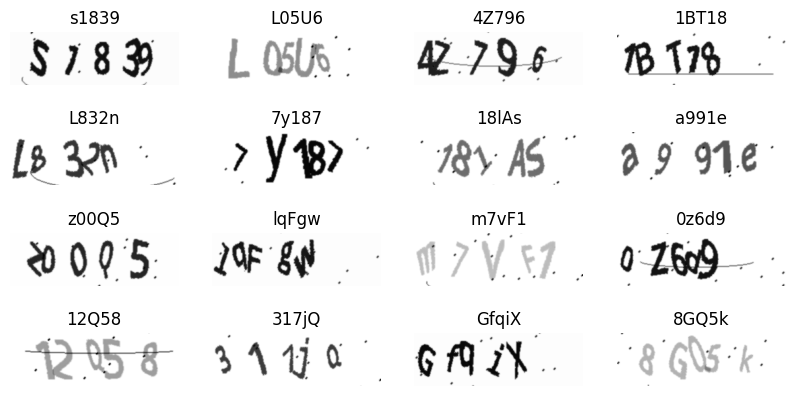

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
random_batch = next(iter(shuffled_dataset.take(1)))
images = random_batch["Image"]
labels = random_batch["Label"]
for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        img = np.rot90(img, axes=(1,0))
        img = np.fliplr(img)
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

**Connectionist Temporal Classification (CTC) Layer**

The CTCLayer in this project is a custom TensorFlow layer designed for text recognition tasks. It computes the Connectionist Temporal Classification (CTC) loss between predicted sequences (*y_pred*) and true sequences (*y_true*). The layer adjusts for the potential mismatch in lengths between input data (like images or audio of text) and their corresponding output labels. By incorporating a special 'blank' character and calculating loss over all possible alignments, it enables the model to learn correct sequence predictions for variable-length inputs without predefined alignment, making it key for accurate text recognition.

The conditional probability is adapted from [Graves *et al.*](https://www.cs.toronto.edu/~graves/icml_2006.pdf)

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

**CRNN-CTC Model**

A CRNN model integrating LSTM cells and a CTC layer was developed, following the architecture in [Shi *et al* (2017) ](https://arxiv.org/abs/1507.05717). The model initiates with convolutional layers (Conv2D) using SELU activation and same padding for primary feature extraction from images. This is followed by Max pooling (MaxPool2D) to reduce feature dimensionality. Batch normalization (BatchNormalization) is included after specific convolutional layers to enhance stabilization and training efficiency. For sequence processing, the model utilizes bidirectional LSTM layers (Bidirectional, CuDNNLSTM), critical for capturing sequential dependencies within character series. The architecture progresses to a Map-to-Sequence stage and then to a dense layer (Dense) with SELU activation, facilitating the transition from feature maps to sequence predictions. This is followed by a second batch normalization layer for further stabilization. The final classification of characters is performed by a softmax layer (Dense with softmax activation), determining the probability distribution over the character set. The model employs the Adam optimizer for effective training. A custom CTC loss layer (CTCLayer) is integrated, crucial for sequence alignment; it computes the probability of the target sequence given the model's inputs, enabling the handling of variable-length sequences and alignment between predictions and ground-truth labels without predefined segmentation, a concept inspired by [Graves *et al.*](https://www.cs.toronto.edu/~graves/icml_2006.pdf).

In [ ]:
class CRNN(Model):

  '''
  Convolutional Residual Neural Network

  '''

  def __init__(self):
      super(CRNN, self).__init__()

      # inputs = Input(shape=(32, 128, 1), name="image")
      # labels = layers.Input(name="label", shape=(None,), dtype="float32")

      # Convolution layer 1
      self.conv1 = Conv2D(64, (3, 3), activation = "selu", padding = 'same', name = "Conv1")
      self.pool1 = MaxPool2D(pool_size = (2, 2), strides = 2, name = "MaxPool1")

      # Convlution layer 2
      self.conv2 = Conv2D(128, (3, 3), activation = "selu", padding = 'same', name = "Conv2")
      self.pool2 = MaxPool2D(pool_size = (2, 2), strides = 2, name = "MaxPool2")

      # Convolution layer 3 + 4
      self.conv3 = Conv2D(256, (3, 3), activation = "selu", padding = 'same', name = "Conv3")
      self.conv4 = Conv2D(256, (3, 3), activation = "selu", padding = 'same', name = "Conv4")
      self.pool4 = MaxPool2D(pool_size = (2, 1), strides = 2, name = "MaxPool3")

      # Convolution layer 5
      self.conv5 = Conv2D(512, (3, 3), activation = "selu", padding = 'same', name = "Conv5")
      self.batch_norm5 = BatchNormalization(name = "BatchNormalization1")

      # Convolution layer 6
      self.conv6 = Conv2D(512, (3, 3), activation = "selu", padding = 'same', name = "Conv6")
      self.batch_norm6 = BatchNormalization(name = "BatchNormalization2")
      self.pool6 = MaxPool2D(pool_size = (2, 1), strides = 2, name = "MaxPool4")

      # Convolution layer 7
      self.conv7 = Conv2D(512, (2, 2), activation = "selu", padding = 'valid', name = "Conv7")

      # Map-to-Sequeqnce
      self.dense1 = Dense(512, activation = "selu", name= "Dense1")
      # self.drop = layers.Dropout(0.2)
      self.batch_norm = BatchNormalization(name = "BatchNormalization3")

      # Bidirectional-LSTM
      self.blstm1 = Bidirectional(CuDNNLSTM(256, return_sequences=True), name = "Bi-LSTM1")
      self.blstm2 = Bidirectional(CuDNNLSTM(256, return_sequences=True), name = "Bi-LSTM2")

      # Soft-Max
      self.softmax = Dense(len(characters) + 2, activation = 'softmax', name= "Dense2")

      self.CTC = CTCLayer(name = "ctc_loss")


  def call(self, inputs):
    '''
    Forward pass through CRNN

    '''
    image, labels = inputs

    # Convolution Layer 1
    conv1 = self.conv1(image)
    pool1 = self.pool1(conv1)

    # Convolution Layer 2
    conv2 = self.conv2(pool1)
    pool2 = self.pool2(conv2)

    # Convolution Layer 3 + 4
    conv3 = self.conv3(pool2)
    conv4 = self.conv4(conv3)
    pool4 = self.pool4(conv4)

    # Convolution Layer 5
    conv5 = self.conv5(pool4)
    batch_norm5 = self.batch_norm5(conv5)

    # Convolution Layer 6
    conv6 = self.conv6(batch_norm5)
    batch_norm6 = self.batch_norm6(conv6)
    pool6 = self.pool6(batch_norm6)

    # Convolution Layer 7
    conv7 = self.conv7(conv6)

    # Map-to-Sequence
    conv7_shape = conv7.shape
    new_shape = (conv7_shape[1], conv7_shape[2] * conv7_shape[3])  # Adjusted to match the tensor's total size
    reshaped = layers.Reshape(target_shape=new_shape, name= "reshape")(conv7)
    dense1 = self.dense1(reshaped)
    drop1 = self.batch_norm(dense1)

    # Bidirectiona-LSTM
    blstm1 = self.blstm1(drop1)
    blstm2 = self.blstm2(blstm1)

    # Softmax
    softmax_output = self.softmax(blstm2)

    # CTC
    output_logits = self.CTC(labels, softmax_output)
    return output_logits

  def build_model(self):
      inputs = [layers.Input(shape=(img_width, img_height, 1), name="Image", dtype="float32"),
                layers.Input(name="Label", shape=(None,), dtype="float32")]
      outputs = self.call(inputs)
      optimizer = Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, clipnorm=clip_norm)
      model = keras.models.Model(inputs=inputs, outputs=outputs, name="ocr_model_captcha")
      model.compile(optimizer=optimizer)
      return model


**Training Loop**

In [ ]:
ocr_model = CRNN()
model = ocr_model.build_model()

print(model.summary())


Model: "ocr_model_captcha"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Image (InputLayer)          [(None, 256, 80, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 80, 64)          640       ['Image[0][0]']               
                                                                                                  
 MaxPool1 (MaxPooling2D)     (None, 128, 40, 64)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 128, 40, 128)         73856     ['MaxPool1[0][0]']            
                                                                                  

In [ ]:
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    shuffle = True
)

Epoch 1/100
515/515 [==============================] - 136s 231ms/step - loss: 20.0378 - val_loss: 26.1483 - lr: 0.0010
Epoch 2/100
515/515 [==============================] - 112s 216ms/step - loss: 6.3933 - val_loss: 5.4840 - lr: 0.0010
Epoch 3/100
515/515 [==============================] - 112s 217ms/step - loss: 0.8009 - val_loss: 6.8911 - lr: 0.0010
Epoch 4/100
515/515 [==============================] - 112s 217ms/step - loss: 0.3990 - val_loss: 3.6110 - lr: 0.0010
Epoch 5/100
515/515 [==============================] - 111s 216ms/step - loss: 0.2763 - val_loss: 21.5224 - lr: 0.0010
Epoch 6/100
515/515 [==============================] - 112s 216ms/step - loss: 0.2132 - val_loss: 0.6398 - lr: 0.0010
Epoch 7/100
515/515 [==============================] - 113s 219ms/step - loss: 0.1749 - val_loss: 0.8916 - lr: 0.0010
Epoch 8/100
515/515 [==============================] - 112s 218ms/step - loss: 0.1498 - val_loss: 0.4424 - lr: 0.0010
Epoch 9/100
515/515 [==============================] 

In [47]:
model.save('my_captcha_model.keras')

**Testing**

In [ ]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []

    pred_indices = np.argmax(predictions, axis=2) - 1
    # print(pred_indices)

    for i in range(pred_indices.shape[0]):
        ans = ""

        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]

        ## remove blanks
        for p in merged_list:
            if p != len(characters):
                ans += characters[int(p)]

        text_list.append(ans)

    return text_list

In [ ]:
model.load_weights('my_captcha_model.keras')

In [ ]:
prediction_model = Model(model.get_layer(name="Image").input, model.get_layer(name="Dense2").output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image (InputLayer)          [(None, 256, 80, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 80, 64)       640       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 128, 40, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 40, 128)      73856     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 64, 20, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 64, 20, 256)       295168    
                                                                 
 Conv4 (Conv2D)              (None, 64, 20, 256)       590080

In [ ]:
correct_predictions = 0
total_predictions = 0

for batch in test_dataset:  # Iterate over the entire test dataset
    batch_images = batch["Image"]
    batch_labels = batch["Label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        if pred_texts[i] == orig_texts[i]:
            correct_predictions += 1

    total_predictions += len(pred_texts)


# Calculate overall accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


3/3 [==============================] - 1s 292ms/step
Overall Accuracy: 95.53%


4/4 [==============================] - 0s 14ms/step


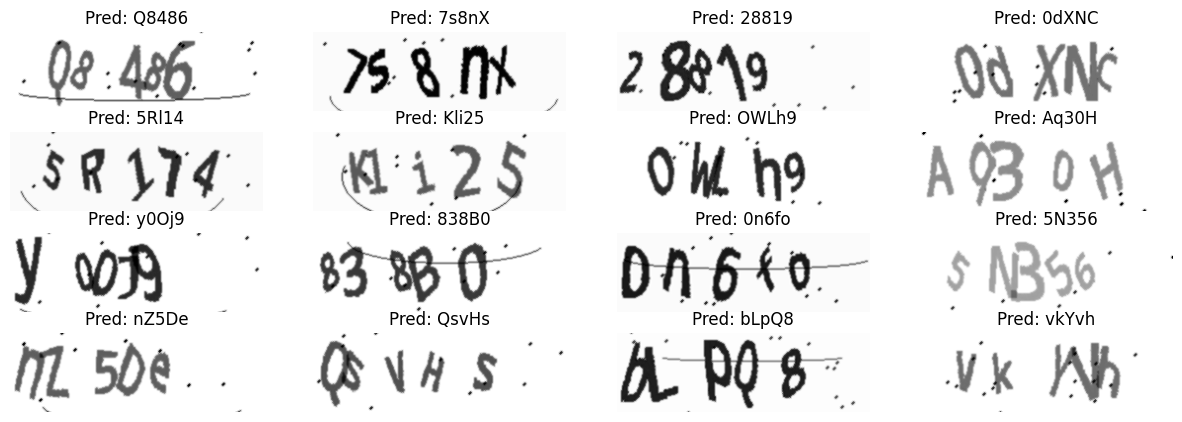

In [ ]:
for batch in test_dataset.take(1):  # Take one batch
    batch_images = batch["Image"]
    batch_labels = batch["Label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # Plot the images with predictions and original labels
    fig, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):
        if i < len(batch_images):
            img = (batch_images[i] * 255).numpy().astype("uint8")
            img = np.rot90(img)
            img = np.flipud(img)
            title = f"Pred: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap = 'gray')
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
